In [1]:
# Research paper: Understanding deeplearning requires rethinking generalization
# https://arxiv.org/pdf/1611.03530.pdf

# Conclusion: deep neural networks can easily fit the training data whether having or not having any implicit or explicit regularizer to *overfit the training dataset* given #parameters >= #training_samples

# They easily fit even if the labels are partially corrupted, or completely random from uniform distribution and shuffled pixels; They also learn noises that we introduced in dataset.

# Explicit regularization may improve generalization but is neither necessary nor by itself sufficient. 

# Both explicit and implicit regularizers could help to improve the generalization performance. However, it is unlikely that the regularizers are the fundamental reason for generalization.

In [28]:
# load mnist dataset
import tqdm

def fetch(url):
  import requests, gzip, os, numpy, hashlib
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, 'rb') as f:
      data = f.read()
  else:
    with open(fp, 'wb') as f:
      data = requests.get(url).content
      f.write(data)
  return numpy.frombuffer(gzip.decompress(data), dtype=numpy.uint8).copy()

Xtr = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape(-1,28,28)
Ytr = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
Xval= fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape(-1,28,28)
Yval= fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

import numpy as np
XNoise = np.random.uniform(size=(Xtr.shape))
YNoise = np.random.randint(0, 10, size=(len(Xtr),))
Xtr.shape, XNoise.shape, YNoise.shape, Ytr.shape

((60000, 28, 28), (60000, 28, 28), (60000,), (60000,))

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.l1 = nn.Linear(28*28, 228, bias=False)
    self.l2 = nn.Linear(228, 10, bias=False)

  def forward(self, x, y=None):
    x = F.gelu(self.l1(x))
    x = self.l2(x)
    loss = None
    if y is not None:
      loss = F.cross_entropy(x, y)
    return x, loss

In [58]:
model1 = Net() # clean
model2 = Net() # label noise
model3 = Net() # both noise
optim1 = torch.optim.AdamW(model1.parameters(), lr=3e-4)
optim2 = torch.optim.AdamW(model2.parameters(), lr=3e-4)
optim3 = torch.optim.AdamW(model3.parameters(), lr=3e-4)
loss_model = []
loss_label_noise = []
loss_both_noise = []
a1,a2,a3 = [], [], []


# Num params
# sum([p.nelement() for p in model.parameters()])

In [59]:
BS = 32
epoch = 1000

def get_batch(split):
  if split == 'clean':
    x,y = Xtr, Ytr
  elif split == 'ynoise':
    x,y = Xtr, YNoise
  else:
    x,y = XNoise, YNoise

  idx = torch.randint(0, len(x), size=(BS,))
  X = torch.tensor(x[idx]).reshape(-1, 28*28).float()
  Y = torch.tensor(y[idx]).long()
  return X,Y

for i in (t := tqdm.trange(epoch)):
  # clean
  xb, yb = get_batch('clean')
  out,loss1 = model1(xb,yb)
  preds = out.softmax(-1)
  model1.zero_grad()
  loss1.backward()
  optim1.step()
  cat = torch.argmax(preds, dim=-1)
  acc = (cat == yb).float().mean()
  a1.append(acc.item())
  loss_model.append(loss1.item())

  # ynoise
  xb, yb = get_batch('ynoise')
  out,loss2 = model2(xb,yb)
  preds = out.softmax(-1)
  model2.zero_grad()
  loss2.backward()
  optim2.step()
  cat = torch.argmax(preds, dim=-1)
  acc = (cat == yb).float().mean()
  a2.append(acc.item())
  loss_label_noise.append(loss2.item())

  # clean
  xb, yb = get_batch("")
  out,loss3 = model3(xb,yb)
  preds = out.softmax(-1)
  model3.zero_grad()
  loss3.backward()
  optim3.step()
  cat = torch.argmax(preds, dim=-1)
  acc = (cat == yb).float().mean()
  a3.append(acc.item())
  loss_both_noise.append(loss3.item())

  t.set_description(f"{i} | loss: {loss1.item():.4f} | loss: {loss2.item():.4f} | loss: {loss3.item():.4f}")

999 | loss: 0.0093 | loss: 2.3048 | loss: 2.3182: 100%|██████████| 1000/1000 [00:22<00:00, 44.67it/s]


Text(0.5, 1.0, 'accuracy')

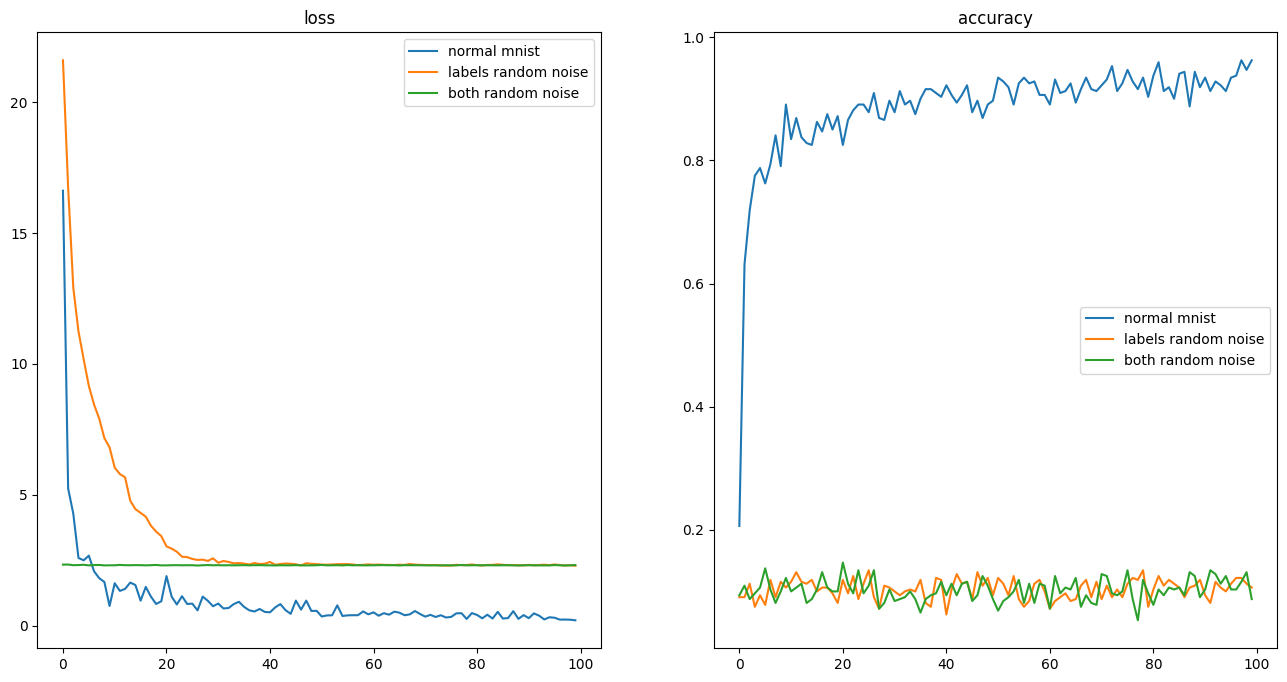

In [60]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
legends = ['normal mnist', 'labels random noise', 'both random noise']
plt.plot(torch.tensor(loss_model).view(-1, 10).mean(-1).tolist())
plt.plot(torch.tensor(loss_label_noise).view(-1, 10).mean(-1).tolist())
plt.plot(torch.tensor(loss_both_noise).view(-1, 10).mean(-1).tolist())
plt.legend(legends)
plt.title("loss")

plt.subplot(1,2,2)
legends = ['normal mnist', 'labels random noise', 'both random noise']
plt.plot(torch.tensor(a1).view(-1, 10).mean(-1).tolist())
plt.plot(torch.tensor(a2).view(-1, 10).mean(-1).tolist())
plt.plot(torch.tensor(a3).view(-1, 10).mean(-1).tolist())
plt.legend(legends)
plt.title("accuracy")